### 使用opensmile提取音频特征

In [122]:
import opensmile
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [123]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 1、构造特征提取函数

In [124]:
from tqdm import tqdm

## 提取特征函数
## file_list:音频文件路径的列表  list类型
## 返回值numpy.ndarray  形状:(len(file_list),88)
def extract_audio_feature(file_list):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals)
    feature = []
    for file in tqdm(file_list, desc="Extracting features"):
        y = smile.process_file(file)
        y = y.to_numpy().reshape(-1)
        feature.append(y)
    print("-------------------------------")
    feature = np.stack(feature, axis=0)
    return feature


In [125]:
## 特征提取示例
file = "./train/Ses01F_impro01_F000.wav"
audio_feature = extract_audio_feature([file])
print(type(audio_feature),audio_feature.shape)

Extracting features: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

-------------------------------
<class 'numpy.ndarray'> (1, 88)


## 2、csv文件读入示例

In [126]:
## 读入csv文件示例
## 由于我们的csv文件使用"#"分隔，需要定义sep参数为"#",否则会读取失败！！！
train_csv = pd.read_csv("./CSVfile/train.csv",sep="#")

In [127]:
## 快速查看前5条数据
train_csv.head(5)

,num,id,path,text,label
0,1,Ses01F_impro01_F000,train/Ses01F_impro01_F000.wav,Excuse me.,2
1,2,Ses01F_impro01_F001,train/Ses01F_impro01_F001.wav,Yeah.,2
2,3,Ses01F_impro01_F002,train/Ses01F_impro01_F002.wav,Is there a problem?,2
3,4,Ses01F_impro01_F005,train/Ses01F_impro01_F005.wav,Well what's the problem? Let me change it.,2
4,5,Ses01F_impro01_F012,train/Ses01F_impro01_F012.wav,That's out of control.,0


In [128]:
## 统计该csv下lable列不同值的数量
train_csv.value_counts(subset="label")

label
2    1066
1     891
3     696
0     606
Name: count, dtype: int64

Text(0.5, 1.0, 'Train dataset sample distribution')

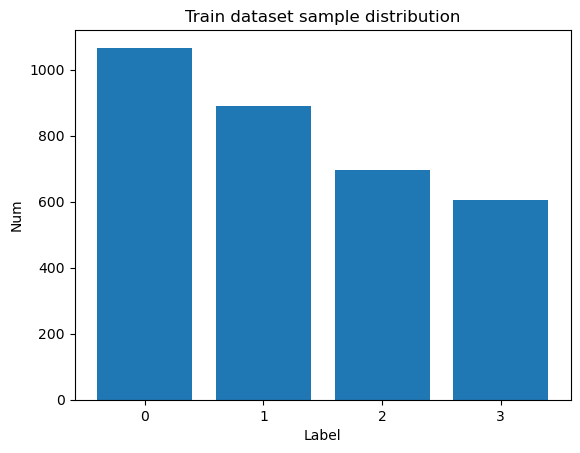

In [129]:
## 画图显示类别数
plt.bar([0,1,2,3],list(train_csv.value_counts(subset="label")),tick_label = ["0","1","2","3"])
plt.xlabel("Label")
plt.ylabel("Num")
plt.title("Train dataset sample distribution")

## 3、性能指标函数

In [130]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [131]:
def calculate_score_classification(preds, labels, average_f1='macro'):  # weighted, macro
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average=average_f1, zero_division=0)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    ua = recall_score(labels, preds, average='macro', zero_division=0)
    confuse_matrix = confusion_matrix(labels, preds)
    return accuracy, ua, f1, precision, confuse_matrix

### 4、构造机器学习模型

In [132]:
# ##使用sklearn实现随机森林
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# ## 这里的myrf类仅为示例，可以自行修改以达到更好的性能
# class MyRF:
#     def __init__(self, **kwargs):
#         self.clf = RandomForestClassifier(**kwargs)
#     def train(self, X, y):
#         self.clf.fit(X, y)
#     def predict(self, X):
#         return self.clf.predict(X)
#     def evaluate(self, X, y):
#         acc, ua, f1, precision, confuse_matrix = calculate_score_classification(self.predict(X), y)
#         return acc, ua, f1, precision, confuse_matrix

In [133]:
from lightgbm import LGBMClassifier

class MyLGBM:
    def __init__(self, **kwargs):
        self.clf = LGBMClassifier(**kwargs)
    def fit(self, X, y):
        self.clf.fit(X, y)
    def predict(self, X):
        return self.clf.predict(X)
    def evaluate(self, X, y):
        acc, ua, f1, precision, confuse_matrix = calculate_score_classification(self.predict(X), y)
        return acc, ua, f1, precision, confuse_matrix

## 5、读取csv文件，分离音频文件路径、标签

In [134]:
## 读取train.csv、dev.csv
train_csv = pd.read_csv("./CSVfile/train.csv", sep = "#")
dev_csv = pd.read_csv("./CSVfile/dev.csv", sep = "#")
## 分离文件路径和标签
## 可先截取少量样本验证代码正确性，再使用所有样本
# train_path = list(train_csv.path)[:100]
# train_label = list(train_csv.label)[:100]
# dev_path = list(dev_csv.path)[:50]
# dev_label = list(dev_csv.label)[:50]

train_path = list(train_csv.path)
train_label = list(train_csv.label)
dev_path = list(dev_csv.path)
dev_label = list(dev_csv.label)

## 6、结果写入函数

In [ ]:
## test_preds 长度为1241的list，对应测试集中1241个样本的标签
##运行后会在当前目录生成result.csv文件，提交result.csv文件即可
##如果没有生成，请检查test_preds的长度是否为1241！
def write_result(test_preds):
    if len(test_preds) != 1241:
        print("错误！请检查test_preds长度是否为1241！！！")
        return -1
    test_csv = pd.read_csv("./CSVfile/test.csv",sep="#")
    test_csv["label"] = test_preds
    test_csv.to_csv("./result.csv",sep = "#")
    print("测试集预测结果已成功写入到文件中！")

## 7、特征预处理函数、主函数

In [ ]:
# ## 提取训练样本特征
# ## 文件数量很多时需要的时间较长，请耐心等待
# train_feature = extract_audio_feature(train_path) ## np.array (n,88)
# df = pd.DataFrame(train_feature)
# df["label"] = train_label
# df.to_csv("train_feature.csv",index = False)

# dev_feature = extract_audio_feature(dev_path)
# df = pd.DataFrame(dev_feature)
# df["label"] = dev_label
# df.to_csv("dev_feature.csv",index = False)

# test_csv = pd.read_csv("./CSVfile/test.csv",sep = "#")
# test_path = list(test_csv.path)
# test_feature = extract_audio_feature(test_path)
# df = pd.DataFrame(test_feature)
# df.to_csv("test_feature.csv",index = False)

In [ ]:
# 加载特征和标签
train_feature = pd.read_csv("train_feature.csv")[:-1]
dev_feature = pd.read_csv("dev_feature.csv")[:-1]
test_feature = pd.read_csv("test_feature.csv")[:]

train_label = train_feature["label"]
dev_label = dev_feature["label"]
train_feature = train_feature.drop(columns = ["label"])
dev_feature = dev_feature.drop(columns = ["label"])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_feature = scaler.fit_transform(train_feature)
dev_feature = scaler.transform(dev_feature)
test_feature = scaler.transform(test_feature)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     'n_estimators': [1, 15, 50, 100, 200, 42],
#     'max_depth': [i for i in range(1, 15)],
#     'min_samples_split': [i for i in range(2, 10)],
#     'min_samples_leaf': [i for i in range(1, 11)],
#     'criterion': ['gini', 'entropy'],
#     'max_features': ['sqrt', 'log2']
# }

# rf = RandomForestClassifier(random_state=1)

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=150,
#     cv=3,
#     verbose=1,
#     random_state=1,
#     n_jobs=-1,
#     error_score='raise'
# )

# random_search.fit(train_feature, train_label)

# print(f"Best parameters found:\n{random_search.best_params_}")

In [140]:
from sklearn.model_selection import cross_val_score, cross_validate
from lightgbm import LGBMClassifier
import numpy as np

# 定义模型
model = LGBMClassifier(
    boosting_type="gbdt",
    num_leaves=12,
    max_depth=None,
    learning_rate=0.01,
    n_estimators=800,
    subsample_for_bin=200000,
    min_split_gain=0.1,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=0.8,
    subsample_freq=2,
    colsample_bytree=0.8,
    reg_alpha=8,
    reg_lambda=1,
    random_state=None,
    n_jobs=-1,
    importance_type="split",
)

# 使用交叉验证评估模型性能
scores = cross_val_score(model, train_feature, train_label, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))

# 使用交叉验证评估模型性能，获取更多指标
cv_results = cross_validate(model, train_feature, train_label, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])
print("Cross-validation results:", cv_results)
print("Average accuracy:", np.mean(cv_results['test_accuracy']))
print("Average F1 score:", np.mean(cv_results['test_f1_macro']))
print("Average precision:", np.mean(cv_results['test_precision_macro']))
print("Average recall:", np.mean(cv_results['test_recall_macro']))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 2606, number of used features: 88
[LightGBM] [Info] Start training from score -1.683487
[LightGBM] [Info] Start training from score -1.296090
[LightGBM] [Info] Start training from score -1.117985
[LightGBM] [Info] Start training from score -1.543007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

KeyboardInterrupt: 

In [ ]:
# 训练模型
best_lgbm = MyLGBM(
    boosting_type="gbdt",
    num_leaves=12,
    max_depth=8,
    learning_rate=0.01,
    n_estimators=800,
    subsample_for_bin=200000,
    min_split_gain=0.1,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=0.8,
    subsample_freq=2,
    colsample_bytree=0.8,
    reg_alpha=6,
    reg_lambda=5.0,
    random_state=None,
    n_jobs=-1,
    importance_type="split",
)

best_lgbm.fit(train_feature, train_label)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 3258, number of used features: 88
[LightGBM] [Info] Start training from score -1.683640
[LightGBM] [Info] Start training from score -1.296524
[LightGBM] [Info] Start training from score -1.117200
[LightGBM] [Info] Start training from score -1.543519


In [ ]:
# best_lgbm = model
# best_lgbm.fit(train_feature, train_label)

# 评估模型在训练集上的表现
acc, ua, f1, precision, confuse_matrix = calculate_score_classification(
    best_lgbm.predict(train_feature), train_label
)
print(
    f"Train:\nacc:{acc}\nua:{ua}\nf1:{f1}\nprecision:{precision}\nconfuse_matrix:\n{confuse_matrix}"
)

# 评估模型在验证集上的表现
acc, ua, f1, precision, confuse_matrix = calculate_score_classification(
    best_lgbm.predict(dev_feature), dev_label
)
print(
    f"Dev:\nacc:{acc}\nua:{ua}\nf1:{f1}\nprecision:{precision}\nconfuse_matrix:\n{confuse_matrix}"
)

Train:
acc:0.8357888275015347
ua:0.8353134495813919
f1:0.8386109699155899
precision:0.8455092075285449
confuse_matrix:
[[495  37  67   6]
 [ 25 691 116  59]
 [ 24  52 924  66]
 [  8  14  61 613]]
Dev:
acc:0.5776699029126213
ua:0.5746186783532332
f1:0.5760500028821663
precision:0.5931413004147841
confuse_matrix:
[[216  50  55   5]
 [ 97 127  67  12]
 [ 15  48 175  20]
 [  4   5  57  77]]


In [ ]:
print(len(test_feature))

1240
